# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
from tsnn.tstorch import transformers
import torch.nn.functional as F
import math
from typing import Optional

from torch import nn
device = 'mps'


plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from dataclasses import dataclass

@dataclass
class Config:
    T: int = 3000
    n_ts: int = 20
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.2
    split_shift: float = 0.2
    split_seasonal: float = 0.0
    split_cs: float = 0.2
    split_cs_shift: float = 0.2
    low_corr: float = 0.05
    high_corr: float = 0.1

In [6]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [7]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 245 ms, sys: 19.1 ms, total: 264 ms
Wall time: 55.8 ms


In [8]:
z.get_dataloader()

### Simple benchmarks

In [9]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(z.train)

In [10]:
lasso.score(z.train)

np.float64(0.09714396330870079)

In [11]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(z.train)

In [12]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [13]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso
optimal,0.183,nan,nan,nan,nan,nan,nan,nan
linear,0.062,0.318,nan,nan,nan,nan,nan,nan
conditional,0.094,0.500,0.005,nan,nan,nan,nan,nan
shift,0.091,0.506,0.002,0.015,nan,nan,nan,nan
cs,0.073,0.416,-0.006,0.006,0.010,nan,nan,nan
cs_shift,0.091,0.493,0.008,0.004,0.008,0.002,nan,nan
lasso,0.097,0.210,0.631,0.005,0.007,0.006,0.008,nan
lr,0.098,0.209,0.631,0.005,0.007,0.005,0.007,0.995


In [14]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso
optimal,0.188,nan,nan,nan,nan,nan,nan,nan
linear,0.064,0.316,nan,nan,nan,nan,nan,nan
conditional,0.092,0.501,0.011,nan,nan,nan,nan,nan
shift,0.094,0.507,0.003,0.010,nan,nan,nan,nan
cs,0.083,0.423,-0.009,0.012,0.020,nan,nan,nan
cs_shift,0.088,0.481,0.005,-0.005,0.003,-0.007,nan,nan
lasso,0.105,0.206,0.623,0.005,0.012,0.006,0.003,nan
lr,0.105,0.204,0.624,0.004,0.010,0.005,0.002,0.995


## Torch benchmarks - narrow matrix (no cross-TS interactions)

### Fully connected

Equivalent to linear regression setup

In [65]:
z.get_dataloader(narrow=True)

In [66]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
                                              )
        
        
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [67]:
m = NeuralNetwork(n_f=Config.n_f).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(m.parameters(), lr=1e-3)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


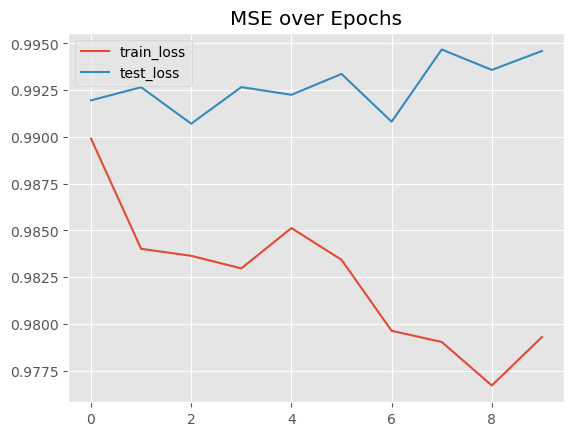

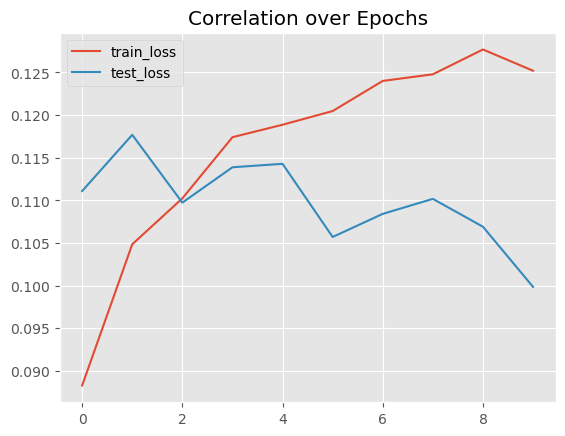

In [68]:
full_nn.fit(z.train, z.test, epochs=10)

In [69]:
comp = benchmark_comparison.Comparator(models=[full_nn, lasso], model_names=['nn', 'lasso'])

In [70]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,nn
optimal,0.140,nan,nan,nan,nan,nan,nan,nan
linear,0.053,0.370,nan,nan,nan,nan,nan,nan
conditional,0.061,0.405,-0.008,nan,nan,nan,nan,nan
shift,0.070,0.509,0.006,0.011,nan,nan,nan,nan
cs,0.085,0.576,0.006,0.007,0.006,nan,nan,nan
cs_shift,0.040,0.358,-0.002,0.007,0.003,0.008,nan,nan
nn,0.153,0.289,0.392,0.321,0.014,0.015,0.006,nan
lasso,0.105,0.191,0.502,-0.005,0.007,0.011,-0.002,0.745


In [71]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,nn
optimal,0.157,nan,nan,nan,nan,nan,nan,nan
linear,0.068,0.374,nan,nan,nan,nan,nan,nan
conditional,0.064,0.405,0.013,nan,nan,nan,nan,nan
shift,0.076,0.518,0.009,0.006,nan,nan,nan,nan
cs,0.091,0.572,0.005,0.008,0.006,nan,nan,nan
cs_shift,0.052,0.364,-0.002,0.004,0.021,0.015,nan,nan
nn,0.101,0.270,0.385,0.326,0.005,-0.002,0.004,nan
lasso,0.107,0.195,0.498,0.009,0.011,0.006,0.006,0.747


### LSTM

Equivalent to linear regression setup

In [72]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [73]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_f, hidden_dim=32):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_f, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.decoder = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, T=10, n_f)
        _, (h, _) = self.encoder(x)
        out = self.decoder(h[-1]) 
        return out

In [74]:
m = LSTMModel(n_f=Config.n_f).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


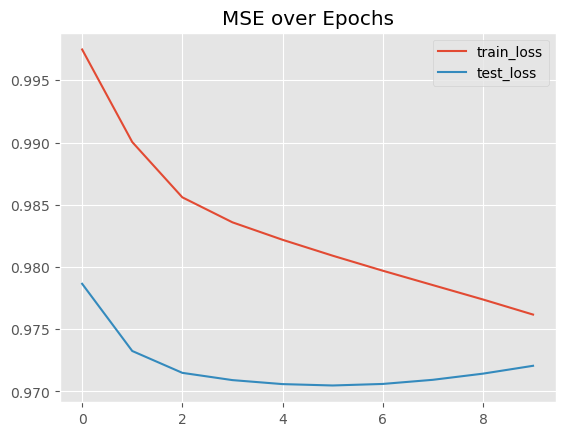

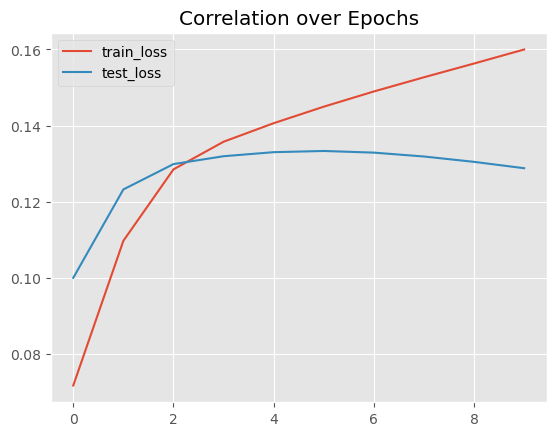

In [75]:
model_lstm.fit(z.train, test=z.test, epochs=10)

In [76]:
comp = benchmark_comparison.Comparator(models=[model_lstm, lasso], model_names=['lstm', 'lasso'])

In [77]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lstm
optimal,0.144,nan,nan,nan,nan,nan,nan,nan
linear,0.054,0.372,nan,nan,nan,nan,nan,nan
conditional,0.068,0.400,-0.006,nan,nan,nan,nan,nan
shift,0.069,0.516,0.011,0.012,nan,nan,nan,nan
cs,0.085,0.575,0.007,0.002,0.009,nan,nan,nan
cs_shift,0.043,0.362,0.001,0.006,0.011,0.011,nan,nan
lstm,0.166,0.494,0.396,0.289,0.452,0.017,0.003,nan
lasso,0.105,0.192,0.502,-0.004,0.008,0.013,-0.003,0.697


In [78]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lstm
optimal,0.148,nan,nan,nan,nan,nan,nan,nan
linear,0.065,0.370,nan,nan,nan,nan,nan,nan
conditional,0.049,0.416,0.008,nan,nan,nan,nan,nan
shift,0.077,0.502,-0.002,0.005,nan,nan,nan,nan
cs,0.090,0.575,0.004,0.019,-0.001,nan,nan,nan
cs_shift,0.044,0.354,-0.008,0.008,0.002,0.009,nan,nan
lstm,0.130,0.490,0.383,0.295,0.452,0.005,0.008,nan
lasso,0.109,0.194,0.499,0.005,0.008,0.002,0.007,0.695


### Transformer

In [79]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [80]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_f, n_rolling, d_model=64, nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.input_dim = n_f
        self.d_model = d_model

        # Linear projection of n_f features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_f)
        # print(x.shape)
        B, n_rolling, n_f = x.shape

        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, src_key_padding_mask=mask, mask=causal_mask)

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        
        # encoded = self.encoder(x, mask=causal_mask)#[: x.size(1), : x.size(1)])
        # out = self.decoder(encoded[:, -1, :]).squeeze(-1)
        # print(out.shape)
        # 1/0
        return out.reshape((-1, 1))

In [81]:
m = TransformerEncoderModel(Config.n_f, 5).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/it]


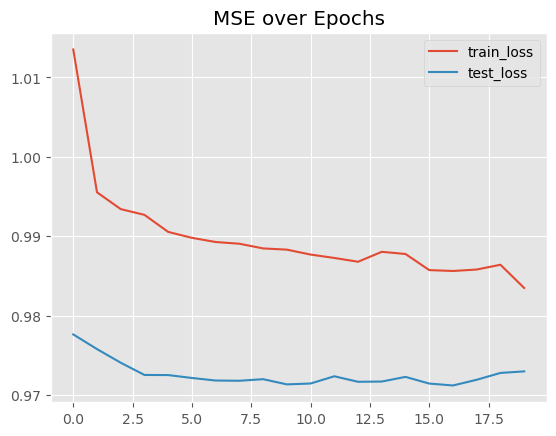

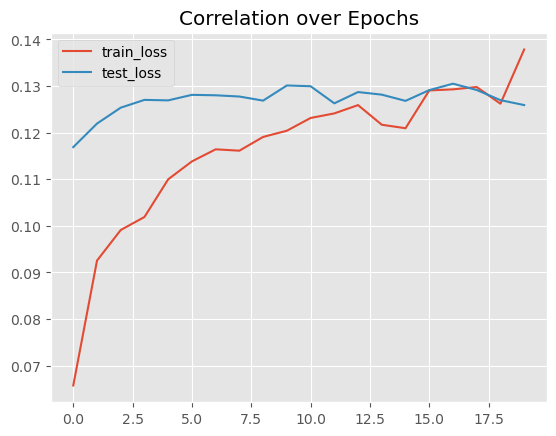

In [82]:
model_torch.fit(z.train, test=z.test, epochs=20)

In [83]:
comp = benchmark_comparison.Comparator(models=[model_torch, lasso], model_names=['transformer', 'lasso'])

In [84]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,transformer
optimal,0.144,nan,nan,nan,nan,nan,nan,nan
linear,0.054,0.372,nan,nan,nan,nan,nan,nan
conditional,0.068,0.400,-0.006,nan,nan,nan,nan,nan
shift,0.069,0.516,0.011,0.012,nan,nan,nan,nan
cs,0.085,0.575,0.007,0.002,0.009,nan,nan,nan
cs_shift,0.043,0.362,0.001,0.006,0.011,0.011,nan,nan
transformer,0.158,0.461,0.428,0.217,0.424,0.014,0.003,nan
lasso,0.105,0.192,0.502,-0.004,0.008,0.013,-0.003,0.740


In [85]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,transformer
optimal,0.148,nan,nan,nan,nan,nan,nan,nan
linear,0.065,0.370,nan,nan,nan,nan,nan,nan
conditional,0.049,0.416,0.008,nan,nan,nan,nan,nan
shift,0.077,0.502,-0.002,0.005,nan,nan,nan,nan
cs,0.090,0.575,0.004,0.019,-0.001,nan,nan,nan
cs_shift,0.044,0.354,-0.008,0.008,0.002,0.009,nan,nan
transformer,0.127,0.457,0.425,0.226,0.416,0.001,0.006,nan
lasso,0.109,0.194,0.499,0.005,0.008,0.002,0.007,0.741


## Torch benchmarks - wide matrix (cross-TS interactions)

### Fully connected

In [86]:
z.get_dataloader()

In [87]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(n_ts*n_f, 512),
        #     nn.ReLU(),
        #     # nn.Linear(512, 512),
        #     # nn.ReLU(),
        #     nn.Linear(512, n_ts),
        # )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [88]:
m = NeuralNetwork(n_ts=Config.n_ts, n_f=Config.n_f).to(device)
# optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)#, weight_decay=1e-2)
optimizer = torch.optim.AdamW(m.parameters(), lr=5e-2, weight_decay=1e-2)
optimizer = torch.optim.SGD(m.parameters(), lr=2e-3)#AdamW(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.11it/s]


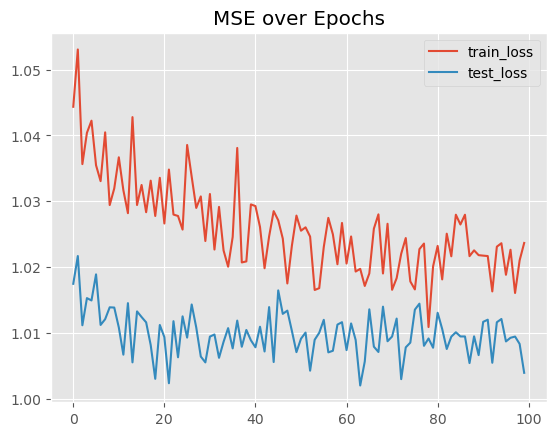

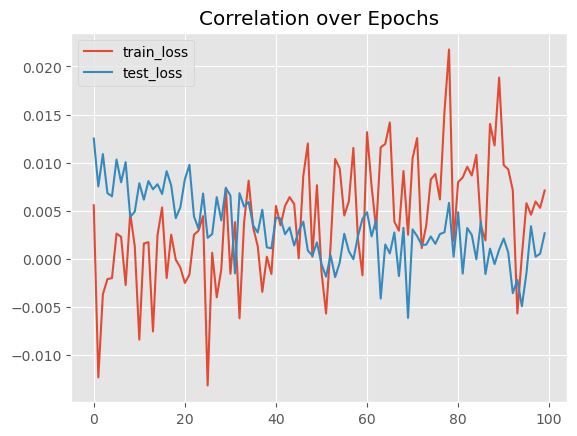

In [89]:
full_nn.fit(z.train, z.test, epochs=100)

In [90]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [91]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.140,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.053,0.370,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.405,-0.008,nan,nan,nan,nan,nan,nan
shift,0.070,0.509,0.006,0.011,nan,nan,nan,nan,nan
cs,0.085,0.576,0.006,0.007,0.006,nan,nan,nan,nan
cs_shift,0.040,0.358,-0.002,0.007,0.003,0.008,nan,nan,nan
lasso,0.105,0.191,0.502,-0.005,0.007,0.011,-0.002,nan,nan
lr,0.106,0.193,0.506,-0.005,0.007,0.011,-0.001,0.998,nan
nn,0.027,0.010,0.002,0.004,0.001,0.016,-0.004,0.001,0.001


In [92]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.157,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.068,0.374,nan,nan,nan,nan,nan,nan,nan
conditional,0.064,0.405,0.013,nan,nan,nan,nan,nan,nan
shift,0.076,0.518,0.009,0.006,nan,nan,nan,nan,nan
cs,0.091,0.572,0.005,0.008,0.006,nan,nan,nan,nan
cs_shift,0.052,0.364,-0.002,0.004,0.021,0.015,nan,nan,nan
lasso,0.107,0.195,0.498,0.009,0.011,0.006,0.006,nan,nan
lr,0.107,0.197,0.502,0.010,0.011,0.006,0.006,0.998,nan
nn,0.001,0.016,0.013,0.009,-0.005,0.011,0.012,0.001,0.001


### LSTM model with 10 timestamps

In [93]:
z.get_dataloader(n_rolling=10, batch_size=1024)

In [94]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [95]:
m = LSTMModel(n_ts=Config.n_ts, n_f=Config.n_f, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.30it/s]


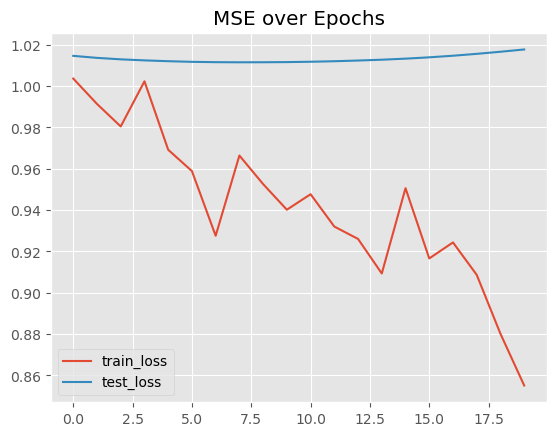

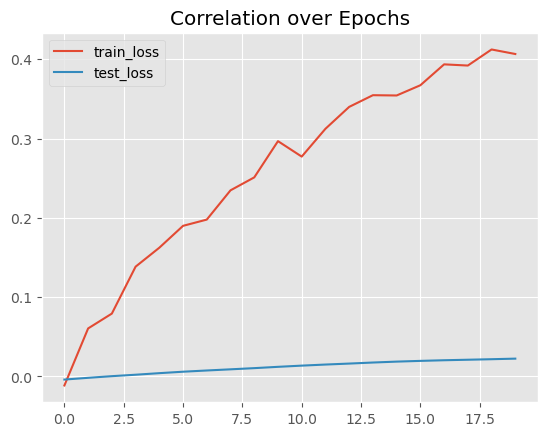

In [96]:
model_lstm.fit(z.train, test=z.test, epochs=20)

In [97]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [98]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.140,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.053,0.370,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.405,-0.008,nan,nan,nan,nan,nan,nan
shift,0.070,0.509,0.006,0.011,nan,nan,nan,nan,nan
cs,0.085,0.576,0.006,0.007,0.006,nan,nan,nan,nan
cs_shift,0.040,0.358,-0.002,0.007,0.003,0.008,nan,nan,nan
lasso,0.105,0.191,0.502,-0.005,0.007,0.011,-0.002,nan,nan
lr,0.106,0.193,0.506,-0.005,0.007,0.011,-0.001,0.998,nan
lstm,0.423,0.141,0.068,0.024,0.041,0.149,0.004,0.143,0.143


In [99]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.157,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.068,0.374,nan,nan,nan,nan,nan,nan,nan
conditional,0.064,0.405,0.013,nan,nan,nan,nan,nan,nan
shift,0.076,0.518,0.009,0.006,nan,nan,nan,nan,nan
cs,0.091,0.572,0.005,0.008,0.006,nan,nan,nan,nan
cs_shift,0.052,0.364,-0.002,0.004,0.021,0.015,nan,nan,nan
lasso,0.107,0.195,0.498,0.009,0.011,0.006,0.006,nan,nan
lr,0.107,0.197,0.502,0.010,0.011,0.006,0.006,0.998,nan
lstm,0.022,0.099,0.059,-0.000,0.030,0.113,-0.002,0.129,0.128


### Transformer

In [168]:
z.get_dataloader(n_rolling=10, roll_y=False)

In [169]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [170]:
def custom_loss(a, b):
    return 1 - torch.corrcoef(a, b)

In [171]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


# model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, loss_fn=nn.L1Loss())
model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, loss_fn=nn.HuberLoss())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


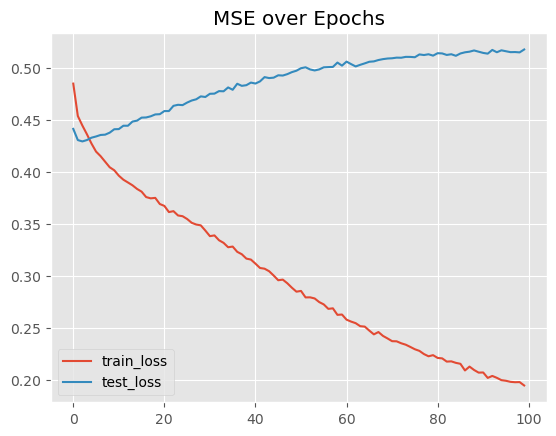

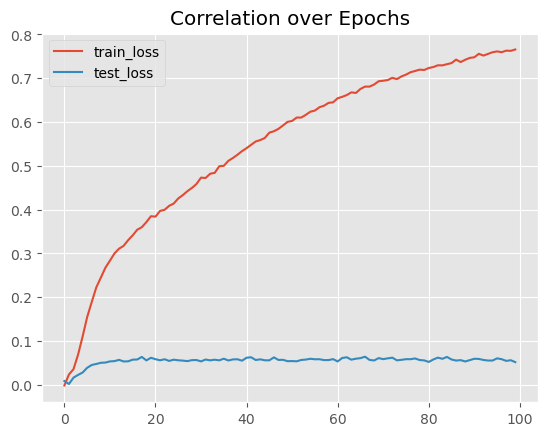

In [172]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [173]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [174]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.183,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.062,0.318,nan,nan,nan,nan,nan,nan,nan
conditional,0.094,0.500,0.005,nan,nan,nan,nan,nan,nan
shift,0.091,0.506,0.002,0.015,nan,nan,nan,nan,nan
cs,0.073,0.416,-0.006,0.006,0.010,nan,nan,nan,nan
cs_shift,0.091,0.493,0.008,0.004,0.008,0.002,nan,nan,nan
lasso,0.097,0.210,0.631,0.005,0.007,0.006,0.008,nan,nan
lr,0.098,0.209,0.631,0.005,0.007,0.005,0.007,0.995,nan
transformer,0.907,0.207,0.097,0.087,0.089,0.114,0.091,0.150,0.151


In [175]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.188,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.064,0.316,nan,nan,nan,nan,nan,nan,nan
conditional,0.092,0.501,0.011,nan,nan,nan,nan,nan,nan
shift,0.094,0.507,0.003,0.010,nan,nan,nan,nan,nan
cs,0.083,0.423,-0.009,0.012,0.020,nan,nan,nan,nan
cs_shift,0.088,0.481,0.005,-0.005,0.003,-0.007,nan,nan,nan
lasso,0.105,0.206,0.623,0.005,0.012,0.006,0.003,nan,nan
lr,0.105,0.204,0.624,0.004,0.010,0.005,0.002,0.995,nan
transformer,0.053,0.121,0.119,-0.001,0.024,0.160,0.014,0.195,0.195


### Re-writing the transformer and checking that we get the same results

In [185]:
z.get_dataloader(n_rolling=5)

In [186]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return (q_idx == kv_idx) | (q_idx == 4) & (kv_idx == 3)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [187]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

,0,1,2,3,4
0,1,0,0,0,0
1,1,1,0,0,0
2,1,1,1,0,0
3,1,1,1,1,0
4,1,1,1,1,1


In [188]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.mask = mask
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [189]:
mask = causal_mask
mask = build_attention_mask(mask, 5, device=device)

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 5, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


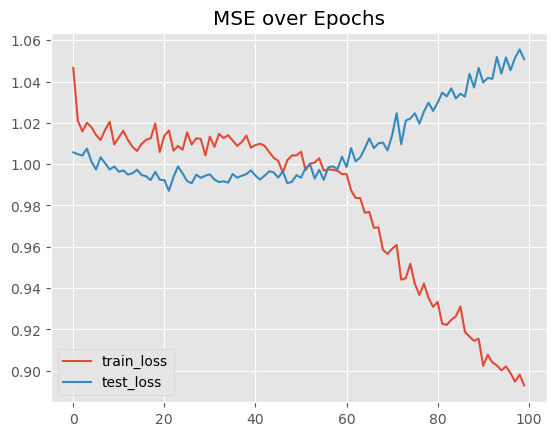

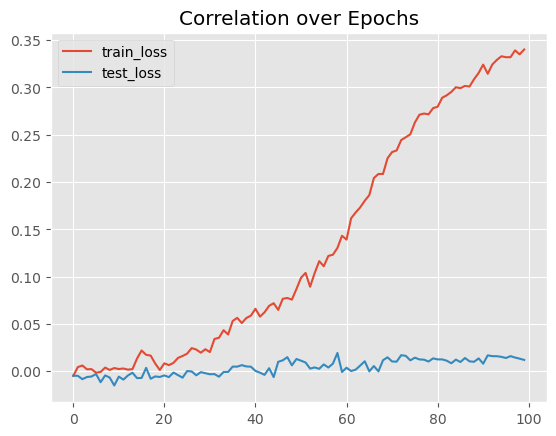

In [190]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [191]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [183]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.183,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.062,0.318,nan,nan,nan,nan,nan,nan,nan
conditional,0.094,0.500,0.005,nan,nan,nan,nan,nan,nan
shift,0.091,0.506,0.002,0.015,nan,nan,nan,nan,nan
cs,0.073,0.416,-0.006,0.006,0.010,nan,nan,nan,nan
cs_shift,0.091,0.493,0.008,0.004,0.008,0.002,nan,nan,nan
lasso,0.097,0.210,0.631,0.005,0.007,0.006,0.008,nan,nan
lr,0.098,0.209,0.631,0.005,0.007,0.005,0.007,0.995,nan
transformer,0.516,0.130,0.084,0.051,0.052,0.066,0.054,0.115,0.116


In [184]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.188,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.064,0.316,nan,nan,nan,nan,nan,nan,nan
conditional,0.092,0.501,0.011,nan,nan,nan,nan,nan,nan
shift,0.094,0.507,0.003,0.010,nan,nan,nan,nan,nan
cs,0.083,0.423,-0.009,0.012,0.020,nan,nan,nan,nan
cs_shift,0.088,0.481,0.005,-0.005,0.003,-0.007,nan,nan,nan
lasso,0.105,0.206,0.623,0.005,0.012,0.006,0.003,nan,nan
lr,0.105,0.204,0.624,0.004,0.010,0.005,0.002,0.995,nan
transformer,0.021,0.065,0.087,-0.006,0.018,0.065,0.011,0.112,0.114


### Transformer with multi-step

In [216]:
z.get_dataloader(n_rolling=5, roll_y=True)

In [217]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return (q_idx == kv_idx) | (q_idx == 4) & (kv_idx == 3)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [218]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

,0,1,2,3,4
0,1,0,0,0,0
1,1,1,0,0,0
2,1,1,1,0,0
3,1,1,1,1,0
4,1,1,1,1,1


In [219]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.mask = mask
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, :, :])  # (B, N)
        return out

In [220]:
mask = causal_mask
mask = build_attention_mask(mask, 5, device=device)

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 5, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]
Traceback (most recent call last):
  File "/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/cyrilgarcia/miniconda3/envs/cyril10/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


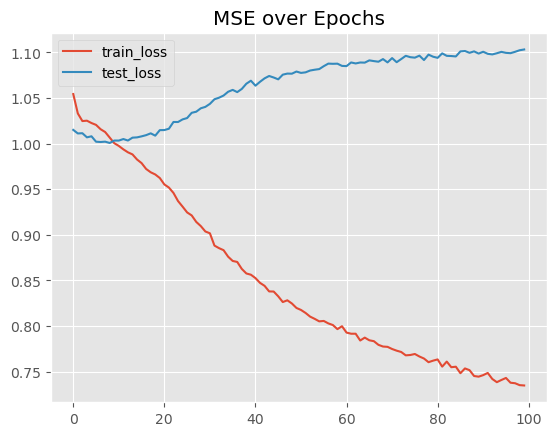

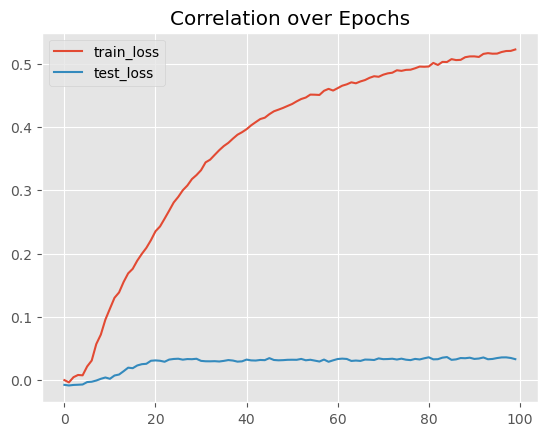

In [221]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [222]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_torch], model_names=['lasso', 'lr', 'transformer'])

In [223]:
comp.correl(z, mode='train')

UserWarning: data dimension mismatch for model transformer, the dataloader object must match the prediction model

In [ ]:
comp.correl(z, mode='test')

### Example of attention deterministic sparsity

In [117]:
z.get_dataloader(n_rolling=10)

##### Rolling mask

In [118]:
def generate_sliding_window(window_size: int) -> _mask_mod_signature:
    def sliding_window(b, h, q_idx, kv_idx):
        return q_idx - kv_idx <= window_size

    sliding_window_mask = and_masks(sliding_window, causal_mask)
    sliding_window_mask.__name__ = f"sliding_window_{window_size}"
    return sliding_window_mask



mask_fn = generate_sliding_window(window_size=2)
plot_mask(mask_fn, seq_len=10)

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,0,0
5,0,0,0,1,1,1,0,0,0,0
6,0,0,0,0,1,1,1,0,0,0
7,0,0,0,0,0,1,1,1,0,0
8,0,0,0,0,0,0,1,1,1,0
9,0,0,0,0,0,0,0,1,1,1


In [119]:
mask = generate_sliding_window(2)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.21it/s]


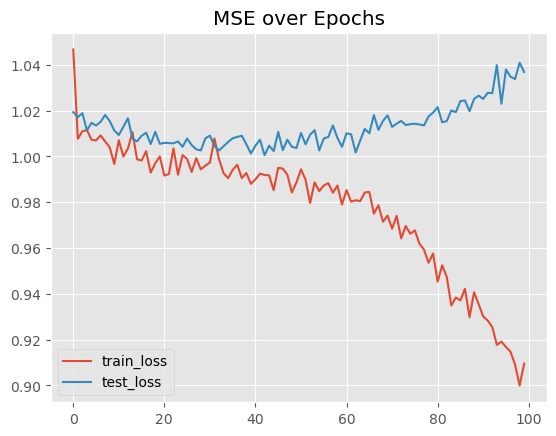

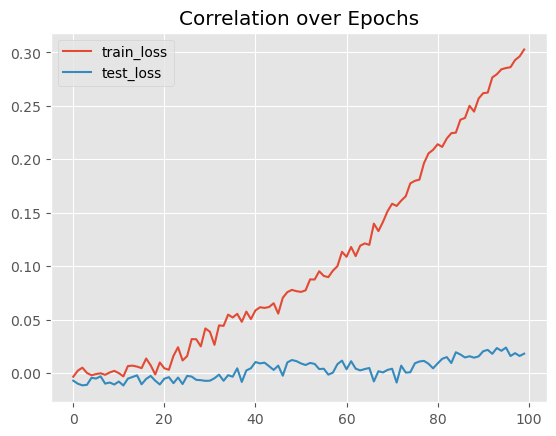

In [120]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [121]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [122]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.140,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.053,0.370,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.405,-0.008,nan,nan,nan,nan,nan,nan,nan
shift,0.070,0.509,0.006,0.011,nan,nan,nan,nan,nan,nan
cs,0.085,0.576,0.006,0.007,0.006,nan,nan,nan,nan,nan
cs_shift,0.040,0.358,-0.002,0.007,0.003,0.008,nan,nan,nan,nan
lasso,0.105,0.191,0.502,-0.005,0.007,0.011,-0.002,nan,nan,nan
lr,0.106,0.193,0.506,-0.005,0.007,0.011,-0.001,0.998,nan,nan
lstm,0.423,0.141,0.068,0.024,0.041,0.149,0.004,0.143,0.143,nan
transformer,0.361,0.087,0.044,0.019,0.031,0.072,0.021,0.095,0.094,0.246


In [123]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr,lstm
optimal,0.157,nan,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.068,0.374,nan,nan,nan,nan,nan,nan,nan,nan
conditional,0.064,0.405,0.013,nan,nan,nan,nan,nan,nan,nan
shift,0.076,0.518,0.009,0.006,nan,nan,nan,nan,nan,nan
cs,0.091,0.572,0.005,0.008,0.006,nan,nan,nan,nan,nan
cs_shift,0.052,0.364,-0.002,0.004,0.021,0.015,nan,nan,nan,nan
lasso,0.107,0.195,0.498,0.009,0.011,0.006,0.006,nan,nan,nan
lr,0.107,0.197,0.502,0.010,0.011,0.006,0.006,0.998,nan,nan
lstm,0.022,0.099,0.059,-0.000,0.030,0.113,-0.002,0.129,0.128,nan
transformer,0.023,0.050,0.035,-0.012,0.013,0.054,0.014,0.070,0.070,0.134


##### Dilation mask

In [124]:
def generate_dilated(dilation: int) -> _mask_mod_signature:
    def dilated_sliding_window(b, h, q_idx, kv_idx):
        diff = torch.abs(q_idx - kv_idx)
        is_dilated = (diff % dilation) == 0
        # is_dilated = diff == 0
        return is_dilated
    
    dilated_sliding_window_mask = and_masks(causal_mask, dilated_sliding_window)
    dilated_sliding_window_mask.__name__ = f"dilation_{dilation}"
    return dilated_sliding_window_mask

mask_fn = generate_dilated(3)
plot_mask(mask_fn, seq_len=10)

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0
5,0,0,1,0,0,1,0,0,0,0
6,1,0,0,1,0,0,1,0,0,0
7,0,1,0,0,1,0,0,1,0,0
8,0,0,1,0,0,1,0,0,1,0
9,1,0,0,1,0,0,1,0,0,1


In [125]:
mask = generate_dilated(dilation=3)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


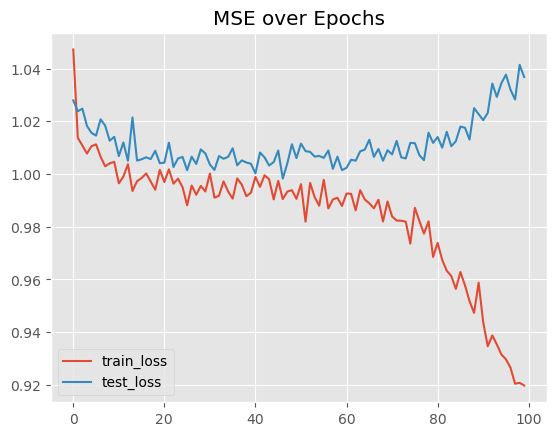

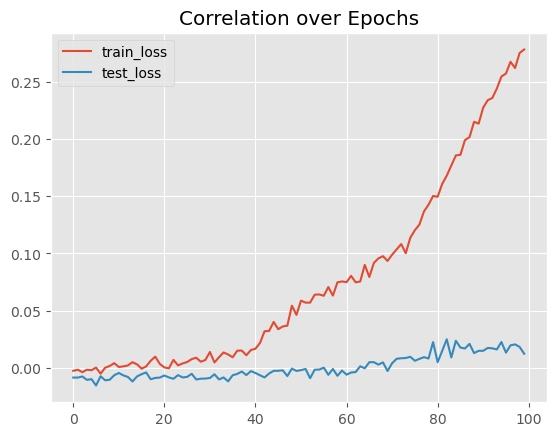

In [126]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [127]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [ ]:
comp.correl(z, mode='train')

In [ ]:
comp.correl(z, mode='test')

##### Dilation mask combined with rolling

In [ ]:
def dilation_rolling(dilation: int, window: int) -> _mask_mod_signature:
    return or_masks(generate_dilated(dilation), generate_sliding_window(window))

mask_fn = dilation_rolling(dilation=3, window=3)
plot_mask(mask_fn, seq_len=10)

In [ ]:
mask = dilation_rolling(dilation=3, window=2)
mask = build_attention_mask(mask, 10, device=device)
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [ ]:
model_torch.fit(z.train, test=z.test, epochs=100)

In [ ]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [ ]:
comp.correl(z, mode='train')

In [ ]:
comp.correl(z, mode='test')

## Sparse Attention

In [ ]:
z.get_dataloader(n_rolling=10)

In [ ]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

# def causal_mask(b, h, q_idx, kv_idx):
#     return q_idx >= (kv_idx+100)

def plot_mask(mask_fn, seq_len=20, title=None, device="cpu"):
    """
    Plot a binary attention mask defined by mask_fn(b,h,q_idx,kv_idx)
    as a (seq_len x seq_len) matrix.
    """
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device) 
    h = torch.zeros(1, device=device)

    mask = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])
    mask = mask.float().cpu()

    return pd.DataFrame(mask).style.background_gradient(axis=None).format(precision=0)

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool


In [ ]:
mask_fn = causal_mask
plot_mask(mask_fn, seq_len=5)

In [ ]:
from torch.nn.attention.flex_attention import BlockMask, _mask_mod_signature, and_masks, or_masks


class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, mask, mask_=None, d_model=128, nhead=8, num_layers=2, dropout=0.5, attn_l1_coeff=0, sparsify=None):
        super().__init__()
        self.mask = mask
        self.sparsify = sparsify
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward = 4 * d_model,
            dropout=dropout,
        )
        self.encoder = transformers.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )
        
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            # nn.Linear(d_model, d_model),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(d_model, n_ts),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_ts, n_ts)
        )
        

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        encoded = self.encoder(x, mask=self.mask, sparsify=self.sparsify)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [ ]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=None).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_causal = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [ ]:
model_causal.fit(z.train, test=z.test, epochs=100)

In [ ]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [ ]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, num_layers=1, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_sparse = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [ ]:
model_sparse.fit(z.train, test=z.test, epochs=400)

In [ ]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_causal, model_sparse], model_names=['lasso', 'lr', 'causal', 'sparse'])

In [ ]:
comp.correl(z, mode='train')

In [ ]:
comp.correl(z, mode='test')

## Dual attention transformer with sparsity and custom mask

In [57]:
z.get_dataloader(n_rolling=10)

In [58]:

# Transformer model with both TS then CS attention.

class DualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,          # number of time series (N)
        n_f,           # number of input features per timestamp
        n_rolling,     # lookback window length (T)
        mask,
        d_model=128,
        nhead_time=8,      # heads for temporal attention (stage 1)
        nhead_series=8,    # heads for cross-series attention (stage 2)
        num_layers_time=1,
        num_layers_series=1,
        dim_feedforward=512,
        dropout=0.8,
        sparsify=None
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.n_rolling = n_rolling
        self.d_model = d_model

        self.mask = mask
        self.sparsify = sparsify
        # ------------------------------------------------------------------
        # 1. Input projection: (n_f) → d_model  (shared across all series & timesteps)
        # ------------------------------------------------------------------
        self.input_proj = nn.Linear(n_f, d_model)

        # Positional encoding for the temporal dimension (stage 1)
        self.pos_emb_time = nn.Parameter(torch.randn(1, n_rolling, d_model))
        # self.pos_emb_time = torch.arange(1, n_rolling)

        # ------------------------------------------------------------------
        # Stage 1: Temporal Transformer (attention over time, independent per series)
        # ------------------------------------------------------------------
        temporal_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_time,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            # activation="gelu",
        )
        self.temporal_transformer = transformers.TransformerEncoder(
            temporal_layer, num_layers=num_layers_time
        )

        # ------------------------------------------------------------------
        # Stage 2: Cross-Series Transformer (attention over the N series)
        # ------------------------------------------------------------------
        series_layer = transformers.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_series,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            # activation="gelu",
        )
        self.series_transformer = transformers.TransformerEncoder(
            series_layer, num_layers=num_layers_series
        )

        # Optional positional encoding for the series dimension
        # (can be learned or fixed; here learned)
        
        self.pos_emb_series = nn.Parameter(torch.randn(1, n_ts, d_model))
        # self.pos_emb_series = torch.arange(1, n_ts)

        # ------------------------------------------------------------------
        # Final prediction head: d_model → 1 (forecast scalar per series)
        # ------------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x : (B, n_rolling, n_ts, n_f)   float tensor
        Returns: (B, n_ts)               predicted scalar for each series
        """
        B, T, N, F = x.shape  # T = n_rolling, N = n_ts, F = n_f

        # ------------------------------------------------------------------
        # 1. Project features → d_model
        # ------------------------------------------------------------------
        # (B, T, N, F) → (B, T, N, d_model)
        x = self.input_proj(x)

        # ------------------------------------------------------------------
        # 2. Reshape so that batch × series becomes the new "batch"
        #    → (B*N, T, d_model)
        # ------------------------------------------------------------------
        x = x.permute(0, 2, 1, 3).reshape(B * N, T, self.d_model)  # (B*N, T, d_model)

        # Add temporal positional encoding
        x = x + self.pos_emb_time[:, :T, :]

        # ------------------------------------------------------------------
        # 3. Temporal Transformer (causal attention over time)
        # ------------------------------------------------------------------
        # x = self.temporal_transformer(x, mask=self.causal_mask_time)  # (B*N, T, d_model)
        x = self.temporal_transformer(x, mask=self.mask, sparsify=self.sparsify)  # (B*N, T, d_model)

        # Take the last timestep representation
        x_last = x[:, -1, :]  # (B*N, d_model)

        # ------------------------------------------------------------------
        # 4. Reshape back to have series dimension explicit
        #    → (B, N, d_model)
        # ------------------------------------------------------------------
        x_series = x_last.view(B, N, self.d_model)

        # Add series positional encoding
        x_series = x_series + self.pos_emb_series

        # ------------------------------------------------------------------
        # 5. Cross-Series Transformer (full attention over the N series)
        # ------------------------------------------------------------------
        # No mask needed here → full bidirectional attention across series
        x_series = self.series_transformer(x_series, sparsify=self.sparsify)  # (B, N, d_model)

        # ------------------------------------------------------------------
        # 6. Final prediction
        # ------------------------------------------------------------------
        out = self.output_head(x_series)      # (B, N, 1)
        out = out.squeeze(-1)                 # (B, N) = (B, n_ts)

        return out

In [59]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=3):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [60]:
mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

m = DualAttentionTransformer(Config.n_ts, Config.n_f, 10, mask=mask, dropout=0.5, dim_feedforward=128, sparsify=keep_topk_per_row).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(m.parameters(), lr=0.001)


model_causal = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.77s/it]


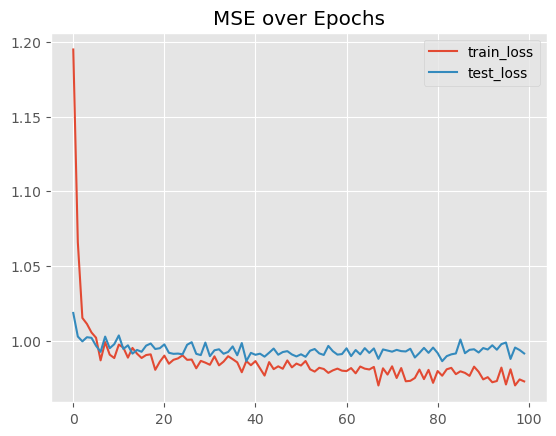

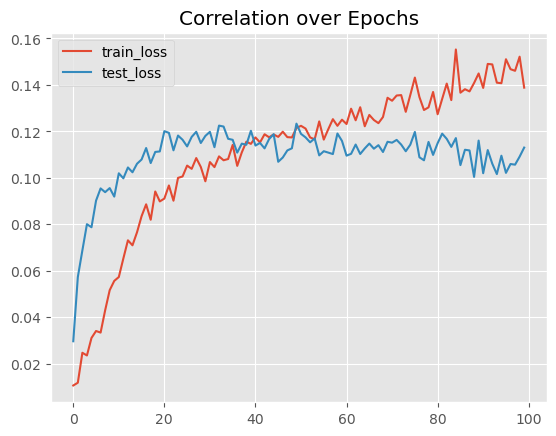

In [61]:
model_causal.fit(z.train, test=z.test, epochs=100)

In [62]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_causal], model_names=['lasso', 'lr', 'causal'])

In [63]:
comp.correl(z, mode='train')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.140,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.053,0.370,nan,nan,nan,nan,nan,nan,nan
conditional,0.061,0.405,-0.008,nan,nan,nan,nan,nan,nan
shift,0.070,0.509,0.006,0.011,nan,nan,nan,nan,nan
cs,0.085,0.576,0.006,0.007,0.006,nan,nan,nan,nan
cs_shift,0.040,0.358,-0.002,0.007,0.003,0.008,nan,nan,nan
lasso,0.105,0.191,0.502,-0.005,0.007,0.011,-0.002,nan,nan
lr,0.106,0.193,0.506,-0.005,0.007,0.011,-0.001,0.998,nan
causal,0.165,0.365,0.355,0.097,0.362,0.027,0.002,0.674,0.677


In [64]:
comp.correl(z, mode='test')

,true,optimal,linear,conditional,shift,cs,cs_shift,lasso,lr
optimal,0.157,nan,nan,nan,nan,nan,nan,nan,nan
linear,0.068,0.374,nan,nan,nan,nan,nan,nan,nan
conditional,0.064,0.405,0.013,nan,nan,nan,nan,nan,nan
shift,0.076,0.518,0.009,0.006,nan,nan,nan,nan,nan
cs,0.091,0.572,0.005,0.008,0.006,nan,nan,nan,nan
cs_shift,0.052,0.364,-0.002,0.004,0.021,0.015,nan,nan,nan
lasso,0.107,0.195,0.498,0.009,0.011,0.006,0.006,nan,nan
lr,0.107,0.197,0.502,0.010,0.011,0.006,0.006,0.998,nan
causal,0.106,0.366,0.347,0.099,0.378,0.013,0.014,0.664,0.668
